In [7]:
import torch
from model import *
import numpy as np
import os
import random
import torch.optim as optim
import torch.nn as nn
from Myloader import *
import time
import torchvision.models as models
from torchmetrics.classification import MultilabelAveragePrecision
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def evaluate(model, val_loader):
    model.eval()
    test_running_loss = 0.0
    test_total = 0

    with torch.no_grad():
        record_target_label = torch.zeros(1, 19).to(device)
        record_predict_label = torch.zeros(1, 19).to(device)
        for (test_imgs, test_labels, test_dicoms) in val_loader:
            test_imgs = test_imgs.to(device)
            test_labels = test_labels.to(device)
            test_labels = test_labels.squeeze(-1)

            test_output = model(test_imgs)
            loss = criterion(test_output, test_labels)

            test_running_loss += loss.item() * test_imgs.size(0)
            test_total += test_imgs.size(0)

            record_target_label = torch.cat((record_target_label, test_labels), 0)
            record_predict_label = torch.cat((record_predict_label, test_output), 0)


        record_target_label = record_target_label[1::]
        record_predict_label = record_predict_label[1::]

        metric = MultilabelAveragePrecision(num_labels=19, average="macro", thresholds=None)
        mAP = metric(record_predict_label, record_target_label.to(torch.int32))

    return mAP, test_running_loss, test_total

In [9]:
# set_seed(123)
#     weight_dir = ""
#     if not os.path.exists(weight_dir):
#         os.makedirs(weight_dir)

epochs = 100
batch_size = 32
num_classes = 19

weight_path = "weights/"

train_path = "data/MICCAI_long_tail_train.tfrecords"
train_index = "data/MICCAI_long_tail_train.tfindex"
val_path = "data/MICCAI_long_tail_val.tfrecords"
val_index = "data/MICCAI_long_tail_val.tfindex"
opt_lr = 1e-4
weight_decay = 0
training = True
train_name = ""
val_name = ""

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder = ResnetEncoder(num_layers=18, embDimension=num_classes).to(device)
# checkpoint = torch.load(weight_path + "/{}epoch.pt".format(10))
# encoder.load_state_dict(checkpoint['model_state_dict'])
opt = optim.Adam(encoder.parameters(), lr=opt_lr, weight_decay = weight_decay)
train_loader = Myloader(train_path, train_index, batch_size, num_workers=0, shuffle=True)
val_loader = Myloader(val_path, val_index, batch_size, num_workers=0, shuffle=False)

criterion = nn.BCEWithLogitsLoss()

cuda


In [20]:
def evaluate2(model, val_loader):
    model.eval()
    test_running_loss = 0.0
    test_total = 0

    with torch.no_grad():
        record_target_label = torch.zeros(1, 19).to(device)
        record_predict_label = torch.zeros(1, 19).to(device)
        cnt = 0
        for (test_imgs, test_labels, test_dicoms) in val_loader:
            cnt += 1
            if cnt % 50 == 0:
                print("Progress - {} / {}".format(cnt*batch_size, 20000))
            test_imgs = test_imgs.to(device)
            test_labels = test_labels.to(device)
            test_labels = test_labels.squeeze(-1)

            test_output = model(test_imgs)
            loss = criterion(test_output, test_labels)

            test_running_loss += loss.item() * test_imgs.size(0)
            test_total += test_imgs.size(0)

            record_target_label = torch.cat((record_target_label, test_labels), 0)
            record_predict_label = torch.cat((record_predict_label, test_output), 0)


        record_target_label = record_target_label[1::]
        record_predict_label = record_predict_label[1::]

        # Convert tensors to NumPy arrays
        y_true = record_target_label.cpu().numpy()
        y_scores = record_predict_label.cpu().numpy()

        average_precisions = []
        for i in range(y_true.shape[1]):
            average_precisions.append(average_precision_score(y_true[:, i], y_scores[:, i]))

            
        return average_precisions

In [21]:
ap = evaluate2(encoder, val_loader)

Progress - 1600 / 20000
Progress - 3200 / 20000
Progress - 4800 / 20000
Progress - 6400 / 20000
Progress - 8000 / 20000
Progress - 9600 / 20000
Progress - 11200 / 20000
Progress - 12800 / 20000
Progress - 14400 / 20000
Progress - 16000 / 20000
Progress - 17600 / 20000
Progress - 19200 / 20000


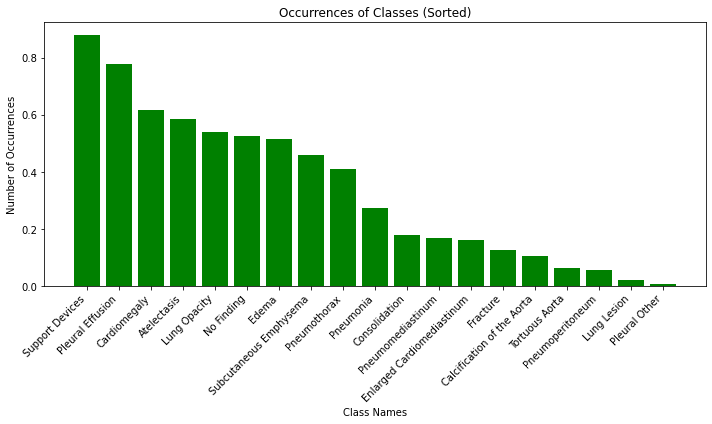

In [30]:
t1_class_names = ['Atelectasis', 'Calcification of the Aorta', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
                  'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other',
                  'Pneumomediastinum', 'Pneumonia', 'Pneumoperitoneum', 'Pneumothorax', 'Subcutaneous Emphysema',
                   'Support Devices', 'Tortuous Aorta']
t1_ap_score = ap

sorted_data = sorted(zip(t1_class_names, t1_ap_score), key=lambda x: x[1], reverse=True)
sorted_class_names, sorted_occurrences = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.bar(sorted_class_names, sorted_occurrences, color='green')
plt.xlabel('Class Names')
plt.ylabel('Number of Occurrences')
plt.title('Occurrences of Classes (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
for i in range(0, 19):
    print(sorted_class_names[i] + ": {}".format(sorted_occurrences[i]))

Support Devices: 0.8793046704112097
Pleural Effusion: 0.7791633954916986
Cardiomegaly: 0.6169515994267407
Atelectasis: 0.5831777671375098
Lung Opacity: 0.5387341883934145
No Finding: 0.5243269391363358
Edema: 0.5154767373804523
Subcutaneous Emphysema: 0.45788259440370405
Pneumothorax: 0.4103346241860422
Pneumonia: 0.2746795695456896
Consolidation: 0.17821099771093418
Pneumomediastinum: 0.1666884318727992
Enlarged Cardiomediastinum: 0.1621054669128692
Fracture: 0.1267133383107479
Calcification of the Aorta: 0.10441446471614746
Tortuous Aorta: 0.061624755636038545
Pneumoperitoneum: 0.056718958119725445
Lung Lesion: 0.019216891069398626
Pleural Other: 0.007358537557629101


In [14]:
print(mAP, test_running_loss, test_total )

tensor(0.1372, device='cuda:0') 15696.87715625763 20360


In [6]:
train_losses = []
test_losses = []

if training == True:
    max_map = 0
    total = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        encoder.train()
        running_loss = 0.0
        start_time = time.time()
        count = 0

        for (imgs, labels, dicom_ids) in train_loader:
            encoder.zero_grad()
            opt.zero_grad()

            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(-1)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                output = encoder(imgs)
                loss = criterion(output, labels)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running_loss += loss.item() * imgs.size(0)
            count += imgs.size(0)

            if count != 0 and count % 1024 == 0 and total == 0:
                print(f"epoch {epoch}: {count}/unknown finished / train loss: {running_loss / count}")

            elif count != 0 and count % 10 == 0 and total != 0:
                print(f"epoch {epoch}: {count}/{total} (%.2f %%) finished / train loss: {running_loss / count}" % (count/total))

        total = count
        mAP, test_running_loss, test_total = evaluate(encoder, val_loader)
        
        train_losses.append(running_loss / count)
        test_losses.append(test_running_loss)
        
        if mAP > max_map:
            max_map = mAP
            torch.save({
                'model_state_dict': encoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
            }, f"{weight_path}/model_best.pt")
        if epoch % 10 == 0:
            torch.save({
                    'model_state_dict': encoder.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                }, weight_path+"/{}epoch.pt".format(epoch))

        end_time = time.time()
        duration = end_time - start_time

        print(f"epoch {epoch} / mAP: {mAP} / test loss: {test_running_loss / test_total} / duration: {duration}")





epoch 0: 1024/unknown finished / train loss: 0.46023833844810724


KeyboardInterrupt: 